In [49]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [50]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [51]:
import model.basic_model as basic_model
import model.agents as agents
from model.stochastic_processes import (
    create_stochastic_avail_price_process,
    plot_price,
)
from model.agents_class import Stake

In [52]:
import os
import sys
print("Current Working Directory:", os.getcwd())
print("Python Path:", sys.path)


Current Working Directory: /Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon
Python Path: ['/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages']


In [53]:
# types
Run = int
Timestep = int

# Price Traj Generation

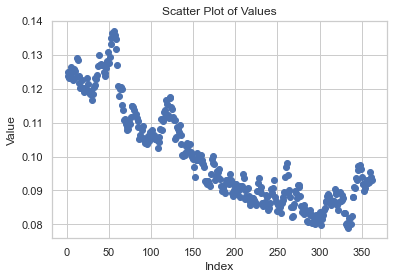

0.0788064508154988


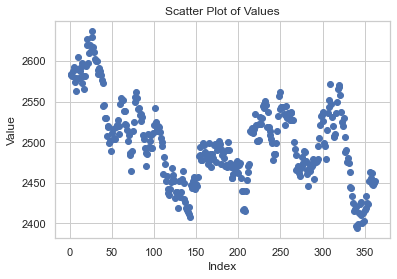

2393.7153476097055


In [54]:
avl_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave',minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0,)
plot_price(avl_price_samples) 
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type = 'concave', minimum_avl_price=1500,target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [55]:
constants = {
}

In [56]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.12377285534758663


In [57]:
ETH_upper_security_pct = [.65]
AVL_upper_security_pct = [.35]

# Simulation

In [58]:
init_agent_eth_alloc = [1, 0]
init_agent_avl_alloc = [1-i for i in init_agent_eth_alloc]
agents_composition = [ETH_upper_security_pct[0],AVL_upper_security_pct[0]] # sum = 1

In [59]:
init_AVL_price = AVL_initial_price
init_fdv = 10000000000 * init_AVL_price
init_inflation_rate = 4
init_rewards_allocation = 20
init_target_avg_yield = 5
init_total_inflation_rewards = init_fdv * init_inflation_rate /100
init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100


init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield

print(init_target_total_security)

198036568.5561386


In [60]:
init_AVL_security_pct = [ i*j for i,j in zip(init_agent_avl_alloc, agents_composition)]
init_ETH_security_pct = [ i*j for i,j in zip(init_agent_eth_alloc, agents_composition)]

print(init_AVL_security_pct, init_ETH_security_pct)

init_total_AVL_security_pct = sum(init_AVL_security_pct)
init_total_ETH_security_pct = sum(init_ETH_security_pct)

print([i/init_total_AVL_security_pct for i in init_AVL_security_pct])
print([i/init_total_ETH_security_pct for i in init_ETH_security_pct])


agents_avl_balance = [init_target_total_security * pct / AVL_initial_price for pct in init_AVL_security_pct]
agents_eth_balance = [init_target_total_security * pct / ETH_initial_price for pct in init_ETH_security_pct]

print(agents_avl_balance)
print(agents_eth_balance)

[0.0, 0.35] [0.65, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[np.float64(0.0), np.float64(559999999.9999999)]
[np.float64(49820.532584713415), np.float64(0.0)]


In [61]:
df = pd.DataFrame({
    'Agent ETH Allocation %': init_agent_eth_alloc,
    'Agent AVL Allocation %': init_agent_avl_alloc
})
df['Agent ETH Allocation %'] = df['Agent ETH Allocation %'].apply(lambda x: f"{x:.2%}")
df['Agent AVL Allocation %'] = df['Agent AVL Allocation %'].apply(lambda x: f"{x:.2%}")
print(df)


avl_normalized = [i / sum(init_AVL_security_pct) for i in init_AVL_security_pct]
eth_normalized = [i / sum(init_ETH_security_pct) for i in init_ETH_security_pct]

df = pd.DataFrame({
    'AVL Security %': avl_normalized,
    'ETH Security %': eth_normalized
})
df['AVL Security %'] = df['AVL Security %'].apply(lambda x: f"{x:.2%}")
df['ETH Security %'] = df['ETH Security %'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'User Total Proportion': agents_composition
})
df['User Total Proportion'] = df['User Total Proportion'].apply(lambda x: f"{x:.2%}")
print(df)


df = pd.DataFrame({
    'Total Security %': [init_total_AVL_security_pct*100, init_total_ETH_security_pct*100]
}, index=['AVL', 'ETH'])
df['Total Security %'] = df['Total Security %'].apply(lambda x: f"{x:.0f}%")
print(df)

  Agent ETH Allocation % Agent AVL Allocation %
0                100.00%                  0.00%
1                  0.00%                100.00%
  AVL Security % ETH Security %
0          0.00%        100.00%
1        100.00%          0.00%
  User Total Proportion
0                65.00%
1                35.00%
    Total Security %
AVL              35%
ETH              65%


In [62]:
@dataclass
class FusionParams:
    # TODO: Set a AVL amount budget cap
    AVL_upper_budget_cap = 1.12e8
    ETH_upper_budget_cap = 2.08e8


    avl_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: avl_price_samples[timestep]]
    )
    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    # inlation % on AVL
    inflation_rate: List[float] = default([init_inflation_rate])

    # % of Rewards Allocated to Fusion
    rewards_allocation: List[float] = default([init_rewards_allocation])


    # Reward Allocation to Pools
    ETH_reward_pct: List[float] = default([20])
    AVL_reward_pct: List[float] = default([80])


    # % of Fusion Security Standard met by ETH Stake
    # TODO: implementation
    ETH_upper_security_pct: List[float] = field(default_factory=lambda: ETH_upper_security_pct)
    AVL_upper_security_pct: List[float] = field(default_factory=lambda: AVL_upper_security_pct)



    # Agents
    ETH_agent_allocation: List[List[float]] = default([
        init_agent_eth_alloc
    ])
    AVL_agent_allocation: List[List[float]] = default([
        init_agent_avl_alloc
    ])
    # Agents_composition: List[List[float]] = default([
    #     agents_composition
    # ])

    # agents_avl_balance: List[List[float]] = default([
    #     agents_avl_balance
    # ])

    # agents_eth_balance: List[List[float]] = default([
    #     agents_eth_balance
    # ])

parameters = FusionParams().__dict__

In [63]:
def update_initial_state(simulation, eth_security_pct, avl_security_pct, avl_price, eth_price):
    # Update the security percentage for ETH and AVL
    agents_composition = [eth_security_pct[0], avl_security_pct[0]]
    init_agent_eth_alloc = [1, 0]
    init_agent_avl_alloc = [1 - i for i in init_agent_eth_alloc]
    
    # Initial conditions
    init_fdv = 10000000000 * avl_price
    init_inflation_rate = 4
    init_rewards_allocation = 20
    init_target_avg_yield = 5
    init_total_inflation_rewards = init_fdv * init_inflation_rate / 100
    init_total_annual_rewards_fusion = init_total_inflation_rewards * init_rewards_allocation / 100
    init_target_total_security = init_total_annual_rewards_fusion * 100 / init_target_avg_yield
    
    # Calculate security percentages
    init_AVL_security_pct = [i * j for i, j in zip(init_agent_avl_alloc, agents_composition)]
    init_ETH_security_pct = [i * j for i, j in zip(init_agent_eth_alloc, agents_composition)]
    
    # Compute balances based on updated percentages
    agents_avl_balance = [init_target_total_security * pct / avl_price for pct in init_AVL_security_pct]
    agents_eth_balance = [init_target_total_security * pct / eth_price for pct in init_ETH_security_pct]
    
    # Update the initial state in the simulation model
    simulation.model.initial_state.update({
        "timestep": 0,
        "avl_price": avl_price,
        "eth_price": eth_price, 
        "AVL_security_pct": sum(init_AVL_security_pct) * 100,
        "ETH_security_pct": sum(init_ETH_security_pct) * 100,
        "total_security": init_target_total_security,
        "total_fdv": init_fdv,
        "total_annual_rewards": init_total_inflation_rewards,
        "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
        "avg_yield": init_target_avg_yield,
        "ETH_stake": Stake(eth_price, agents_eth_balance, 0, 0),
        "AVL_stake": Stake(avl_price, agents_avl_balance, 0, 0),
        "yield_pcts": [0, 0],
        "avg_yield": 0.0,
    })
    
    # Return updated security percentages and balances for confirmation
    return init_AVL_security_pct, init_ETH_security_pct, agents_avl_balance, agents_eth_balance


In [64]:
psub = [
    {
        "policies": {
             },
        "variables": {
            "timestep": basic_model.update_timestep,
            "avl_price": basic_model.update_avl_price,
            "eth_price": basic_model.update_eth_price,
        }
    },
    {
        "policies": {
            "action":basic_model.calc_rewards
             },
        "variables": {
            "total_annual_rewards": basic_model.update_total_annual_rewards,
            "total_annual_rewards_fusion": basic_model.update_total_annual_rewards_fusion,
            "total_fdv": basic_model.update_total_fdv,
        }
    }, 
    {
        "policies": {
            "action": basic_model.calc_security_shares
            },
            "variables": {
                "AVL_security_pct": basic_model.update_AVL_pct,
                "ETH_security_pct": basic_model.update_ETH_pct,
                "total_security": basic_model.update_total_security,
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": basic_model.calc_agents_balances
            },
            "variables": {
                "ETH_stake": basic_model.update_ETH_stake,
                "AVL_stake": basic_model.update_AVL_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_rewards_allocation
            },
            "variables": {
                "AVL_stake": agents.update_AVL_stake,
                "ETH_stake": agents.update_ETH_stake,
            }
    },
    {
        "policies": {
            "action": agents.calc_yields
            },
            "variables": {
                "yield_pcts": agents.update_yields,
                "avg_yield": agents.update_avg_yield,
            }
    },
]

initial_conditions = {
    "timestep": 0,
    "avl_price": AVL_initial_price,
    "eth_price": ETH_initial_price, 
    "AVL_security_pct": sum(init_AVL_security_pct) * 100,
    "ETH_security_pct": sum(init_ETH_security_pct) * 100,
    "total_security": init_target_total_security,
    # "target_total_security": init_target_total_security,
    "total_fdv": init_fdv,
    "total_annual_rewards": init_total_inflation_rewards,
    "total_annual_rewards_fusion": init_total_annual_rewards_fusion,
    "avg_yield": 5.0,
    "ETH_stake": Stake(ETH_initial_price, agents_eth_balance,0,0),
    "AVL_stake": Stake(AVL_initial_price, agents_avl_balance,0,0),
    "yield_pcts": [0,0],
    "avg_yield": 0.0,
}


params = parameters



In [65]:
model1 = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

model2 = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

In [66]:
simulation = []
df = []
for i in range(9):
    simulation.append(Simulation(model=model1, timesteps=100, runs=1))
    ETH_upper_security_pct = 0.1*i+0.1 # starting from 10% to 90%
    simulation[i].model.params.update({
        "ETH_upper_security_pct": [ETH_upper_security_pct],
        "AVL_upper_security_pct": [1-ETH_upper_security_pct],
    })
    update_initial_state(simulation[i], 
                     [ETH_upper_security_pct], 
                     [1-ETH_upper_security_pct], 
                     AVL_initial_price, ETH_initial_price)
    experiment = Experiment([simulation[i]])
    experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
    results  = experiment.run()
    df.append(pd.DataFrame(results))






In [67]:
df[0]

,timestep,avl_price,eth_price,AVL_security_pct,ETH_security_pct,total_security,total_fdv,total_annual_rewards,total_annual_rewards_fusion,avg_yield,ETH_stake,AVL_stake,yield_pcts,simulation,subset,run,substep
0,0,0.123773,2583.749368,90.000000,10.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,0
1,1,0.123773,2583.749368,90.000000,10.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,1
2,1,0.123773,2583.749368,90.000000,10.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,2
3,1,0.123773,2583.749368,90.000000,10.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,3
4,1,0.123773,2583.749368,90.000000,10.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,100,0.105353,2521.210555,88.923218,11.076782,1.737390e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.940179,Stake(initial_price=np.float64(2510.8219563261...,Stake(initial_price=np.float64(0.1072877171050...,"[8.919880990582826, 4.444444444444445]",0,0,1,2
597,100,0.105353,2521.210555,88.701343,11.298657,1.710320e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.940179,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[8.919880990582826, 4.444444444444445]",0,0,1,3
598,100,0.105353,2521.210555,88.701343,11.298657,1.710320e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.940179,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[8.919880990582826, 4.444444444444445]",0,0,1,4
599,100,0.105353,2521.210555,88.701343,11.298657,1.710320e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.940179,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[8.919880990582826, 4.444444444444445]",0,0,1,5


In [68]:
df[1]

,timestep,avl_price,eth_price,AVL_security_pct,ETH_security_pct,total_security,total_fdv,total_annual_rewards,total_annual_rewards_fusion,avg_yield,ETH_stake,AVL_stake,yield_pcts,simulation,subset,run,substep
0,0,0.123773,2583.749368,80.000000,20.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,0
1,1,0.123773,2583.749368,80.000000,20.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,1
2,1,0.123773,2583.749368,80.000000,20.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,2
3,1,0.123773,2583.749368,80.000000,20.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,3
4,1,0.123773,2583.749368,80.000000,20.000000,1.980366e+08,1.237729e+09,4.950914e+07,9.901828e+06,0.000000,Stake(initial_price=np.float64(2583.7493676449...,Stake(initial_price=np.float64(0.1237728553475...,"[0, 0]",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,100,0.105353,2521.210555,78.108353,21.891647,1.758177e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.881772,Stake(initial_price=np.float64(2510.8219563261...,Stake(initial_price=np.float64(0.1072877171050...,"[4.459940495291413, 5.0]",0,0,1,2
597,100,0.105353,2521.210555,77.724117,22.275883,1.734999e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.881772,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[4.459940495291413, 5.0]",0,0,1,3
598,100,0.105353,2521.210555,77.724117,22.275883,1.734999e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.881772,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[4.459940495291413, 5.0]",0,0,1,4
599,100,0.105353,2521.210555,77.724117,22.275883,1.734999e+08,1.053525e+09,4.214102e+07,8.428203e+06,4.881772,Stake(initial_price=np.float64(2521.2105551942...,Stake(initial_price=np.float64(0.1053525430325...,"[4.459940495291413, 5.0]",0,0,1,5


In [69]:
visualizations.plot_token_price_per_subset(
    df[0],
    scenario_names={
        0: "downside",
    }
)

In [70]:
for i in range(9):
    fig= visualizations.plot_security_pct(
        df[i]
    )
    pio.show(fig)


In [71]:
for i in range(9):
    fig = visualizations.plot_avg_overall_yield(
        df[i]
    )
    pio.show(fig)


In [72]:
for i in range(9):
    fig = visualizations.plot_yield_pct(
        df[i], init_agent_eth_alloc
    )
    pio.show(fig)